In [53]:
import sys  
sys.path.insert(0, './machine_learning_models')

from logistic_regression import logistic_regression
from artificial_neural_network import ann_no_validation
from kernel_svm import kernel_svm
from lstm import lstm_no_validation, parse_lstm_data
from naive_bayes import naive_bayes
from random_forest import random_forest
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.models import model_from_json
import pickle
import dill

In [54]:
min_threshold = 1.6
max_threshold = 1.9

In [55]:
def plot_chart(title, x_label, y_label):
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
    plt.show()

In [56]:
def plot_hist(title, x_label, y_label, data):
    plt.hist(data, density=False, bins=20)  # density=False would make counts
    plot_chart(title, x_label, y_label)
    
def plot_bar(title, x_label, y_label, x_data, y_data):
    ax= plt.subplot()
    plt.bar(x_data, y_data) 
    # plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    plt.xticks(fontsize=10, rotation=90)
    plot_chart(title, x_label, y_label)
    
def plot_pie_chart(title, labels, data):
    data_converted = np.unique(data, return_counts=True)[1]
    plt.pie(data_converted, labels = labels, startangle = 90, shadow = True, autopct='%.2f%%')
    plt.title(title)
    plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
    plt.show() 
    

In [57]:
def check_game_with_odds(game, bet_value):
    game_money = 0
    if (game['ODDS_A'] <= game['ODDS_B'] and (game['ODDS_A'] > min_threshold and game['ODDS_A'] < max_threshold)) or (game['ODDS_A'] > game['ODDS_B'] and (game['ODDS_B'] > min_threshold and game['ODDS_B'] < max_threshold)):
        prediction = game['ODDS_A'] <= game['ODDS_B']
        if game['WINNER'] == prediction and game['WINNER'] == 1:
            game_money = (bet_value*game['ODDS_A'] - bet_value)
        elif game['WINNER'] == prediction and game['WINNER'] == 0:
            game_money = (bet_value*game['ODDS_B'] - bet_value)
        else:
            game_money = -bet_value
    return game_money
    
def check_game_with_matchups(game, bet_value):
    game_money = 0
    if (game['MATCHUP_A'] > game['MATCHUP_B'] and (game['ODDS_A'] > min_threshold and game['ODDS_A'] < max_threshold)) or (game['MATCHUP_A'] < game['MATCHUP_B'] and (game['ODDS_B'] > min_threshold and game['ODDS_B'] < max_threshold)):
        prediction = game['MATCHUP_A'] > game['MATCHUP_B']
        if game['WINNER'] == prediction and game['WINNER'] == 1:
            game_money = (bet_value*game['ODDS_A'] - bet_value)
        elif game['WINNER'] == prediction and game['WINNER'] == 0:
            game_money = (bet_value*game['ODDS_B'] - bet_value)
        else:
            game_money = -bet_value
    return game_money

In [58]:
def check_model_performance_on_game_lstm(game, prediction, bet_value):
    game_money = 0
    if (prediction == 1 and (game[1] > min_threshold and game[1] < max_threshold)) or (prediction == 0 and (game[2] > min_threshold and game[2] < max_threshold)):
        if game[3] == prediction and game[3] == 1:
            game_money = (bet_value*game[1] - bet_value)
        elif game[3] == prediction and game[3] == 0:
            game_money = (bet_value*game[2] - bet_value)
        else:
            game_money = -bet_value
    return game_money

In [59]:
def check_model_performance_on_game(game_lstm, prediction, bet_value):
    game_money = 0
    if (prediction == 1 and (game['ODDS_A'] > min_threshold and game['ODDS_A'] < max_threshold)) or (prediction == 0 and (game['ODDS_B'] > min_threshold and game['ODDS_B'] < max_threshold)):
        if game['WINNER'] == prediction and game['WINNER'] == 1:
            game_money = (bet_value*game['ODDS_A'] - bet_value)
        elif game['WINNER'] == prediction and game['WINNER'] == 0:
            game_money = (bet_value*game['ODDS_B'] - bet_value)
        else:
            game_money = -bet_value
    return game_money

In [60]:
def load_neural_net(model_name, model):
    try:
        # load json and create model
        json_file = open('models/{}.json'.format(model_name), 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        res = model_from_json(loaded_model_json)
        # load weights into new model
        res.load_weights("models/{}.h5".format(model_name))
    except:
        res = model(season)[0]
        # serialize model to JSON
        model_json = res.to_json()
        with open("models/{}.json".format(model_name), "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        res.save_weights("models/{}.h5".format(model_name))
    return res

In [61]:
def get_bet_value(prob):
    bet_value = 0 
    if prob >= 0.5:
        bet_value = 10*prob
    else:
        bet_value = 10*abs(1-prob)
    return bet_value
    

In [62]:
season = '2017-2017'
season_test = '2018-2018'
results = []

print('\nGetting data for the {} season for testing...'.format(season.split('-')[0]))

dataset_train = pd.read_csv('./data/{}.csv'.format(season))
dataset_lstm = pd.read_csv('./data/LSTM/{}.csv'.format(season_test))
dataset = pd.read_csv('./data/{}.csv'.format(season_test))

X = dataset.iloc[:, 5:-1].values
y = dataset.iloc[:, -1].values

X_lstm = dataset_lstm.iloc[:, 1:-1].values
y_lstm = dataset_lstm.iloc[:, -1].values


Getting data for the 2017 season for testing...


In [63]:
print('\nExecuting the logistic Regression model...')
Pkl_Filename = "models/LogisticRegressionModel.pkl"  
try:
    with open(Pkl_Filename, 'rb') as file:  
        logisticRegression = pickle.load(file)
except:
    logisticRegression = logistic_regression(season, True)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(logisticRegression, file)
results.append(dict(model='logistic Regression',cm=logisticRegression[0], acc=logisticRegression[1], classifier=logisticRegression[2]))



Executing the logistic Regression model...


In [64]:
print('Executing the Kernel SVM model...')
Pkl_Filename = "models/KernelSVM.pkl"  
try:
    with open(Pkl_Filename, 'rb') as file:  
        res = pickle.load(file)
except:
    res = kernel_svm(season, True)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(res, file)
results.append(dict(model='Kernel SVM',cm=res[0], acc=res[1], classifier=res[2]))

Executing the Kernel SVM model...


In [65]:
print('Executing the Naive Bayes model...')
Pkl_Filename = "models/NaiveBayes.pkl"  
try:
    with open(Pkl_Filename, 'rb') as file:  
        res = pickle.load(file)
except:
    res = naive_bayes(season, True)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(res, file)
results.append(dict(model='Naive Bayes',cm=res[0], acc=res[1], classifier=res[2]))

Executing the Naive Bayes model...


Executing the Random Forest model...


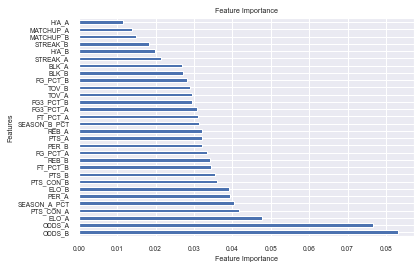

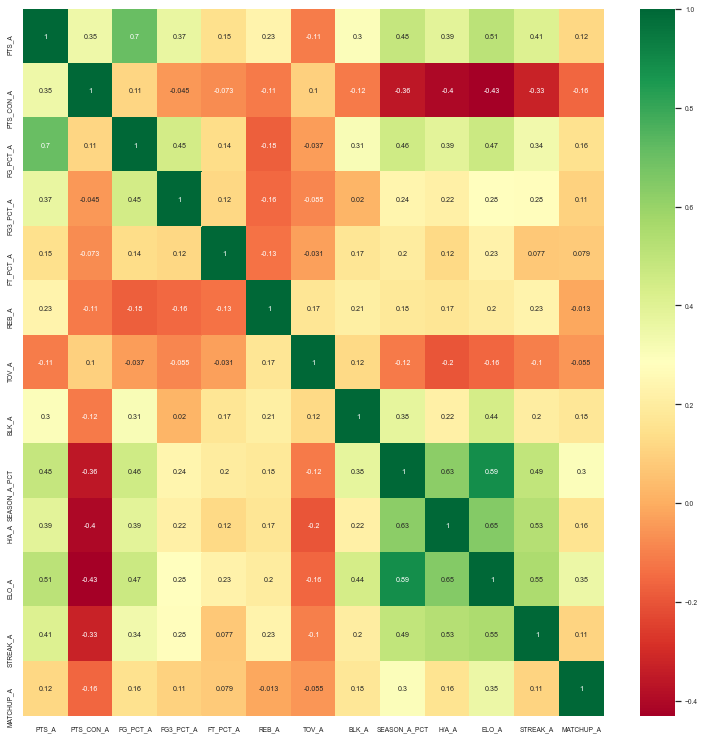

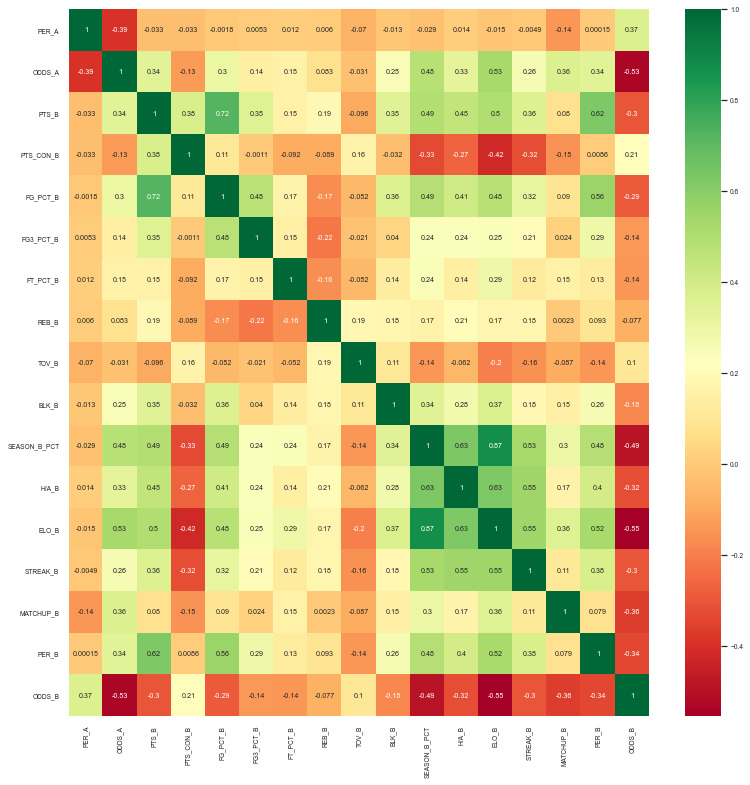

In [66]:
print('Executing the Random Forest model...')
Pkl_Filename = "models/RandomForest.pkl"  
try:
    with open(Pkl_Filename, 'rb') as file:  
        res = pickle.load(file)
except:
    res = random_forest(season, True)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(res, file)
results.append(dict(model='Random Forest',cm=res[0], acc=res[1], classifier=res[2]))

In [67]:
print('Executing the Artificial Neural Network model...')
res = load_neural_net("ANN", ann_no_validation)
results.append(dict(model='ANN', classifier=res))

Executing the Artificial Neural Network model...
Epoch 1/100
36/36 [==============================] - 1s 3ms/step - loss: 543.1186 - accuracy: 0.5039
Epoch 2/100
36/36 [==============================] - 0s 3ms/step - loss: 382.9840 - accuracy: 0.5135
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 244.8668 - accuracy: 0.5013
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 173.9393 - accuracy: 0.5170
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 104.1860 - accuracy: 0.5127
Epoch 6/100
36/36 [==============================] - 0s 2ms/step - loss: 62.4429 - accuracy: 0.5066
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 24.2361 - accuracy: 0.5301
Epoch 8/100
36/36 [==============================] - 0s 2ms/step - loss: 4.8971 - accuracy: 0.5336
Epoch 9/100
36/36 [==============================] - 0s 2ms/step - loss: 1.2910 - accuracy: 0.5520
Epoch 10/100
36/36 [============================

36/36 [==============================] - 0s 2ms/step - loss: 0.7233 - accuracy: 0.5782
Epoch 83/100
36/36 [==============================] - 0s 2ms/step - loss: 0.7235 - accuracy: 0.5782
Epoch 84/100
36/36 [==============================] - 0s 2ms/step - loss: 0.7343 - accuracy: 0.5764
Epoch 85/100
36/36 [==============================] - 0s 2ms/step - loss: 0.7388 - accuracy: 0.5773
Epoch 86/100
36/36 [==============================] - 0s 2ms/step - loss: 0.7234 - accuracy: 0.5782
Epoch 87/100
36/36 [==============================] - 0s 2ms/step - loss: 0.7230 - accuracy: 0.5782
Epoch 88/100
36/36 [==============================] - 0s 2ms/step - loss: 0.7294 - accuracy: 0.5773
Epoch 89/100
36/36 [==============================] - 0s 2ms/step - loss: 0.7230 - accuracy: 0.5782
Epoch 90/100
36/36 [==============================] - 0s 2ms/step - loss: 0.7229 - accuracy: 0.5782
Epoch 91/100
36/36 [==============================] - 0s 2ms/step - loss: 0.7237 - accuracy: 0.5773
Epoch 92/100


In [68]:
print('Executing the LSTM model...')
res = load_neural_net("LSTM", lstm_no_validation)
results.append(dict(model='LSTM', classifier=res))

Executing the LSTM model...
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12)                2160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 13        
Total params: 2,173
Trainable params: 2,173
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 2s 7ms/step - loss: 0.7339 - accuracy: 0.5426
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.7272 - accuracy: 0.5680
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.7253 - accuracy: 0.5609
Epoch 4/100
31/31 [==============================] - 0s 6

31/31 [==============================] - 0s 6ms/step - loss: 0.6351 - accuracy: 0.6521
Epoch 76/100
31/31 [==============================] - 0s 6ms/step - loss: 0.6183 - accuracy: 0.6471
Epoch 77/100
31/31 [==============================] - 0s 6ms/step - loss: 0.6150 - accuracy: 0.6471
Epoch 78/100
31/31 [==============================] - 0s 7ms/step - loss: 0.6231 - accuracy: 0.6258
Epoch 79/100
31/31 [==============================] - 0s 6ms/step - loss: 0.6196 - accuracy: 0.6521
Epoch 80/100
31/31 [==============================] - 0s 6ms/step - loss: 0.6171 - accuracy: 0.6572
Epoch 81/100
31/31 [==============================] - 0s 6ms/step - loss: 0.6295 - accuracy: 0.6481
Epoch 82/100
31/31 [==============================] - 0s 6ms/step - loss: 0.6205 - accuracy: 0.6329
Epoch 83/100
31/31 [==============================] - 0s 7ms/step - loss: 0.6244 - accuracy: 0.6318
Epoch 84/100
31/31 [==============================] - 0s 7ms/step - loss: 0.6244 - accuracy: 0.6339
Epoch 85/100



Getting the feature correlation matrix...


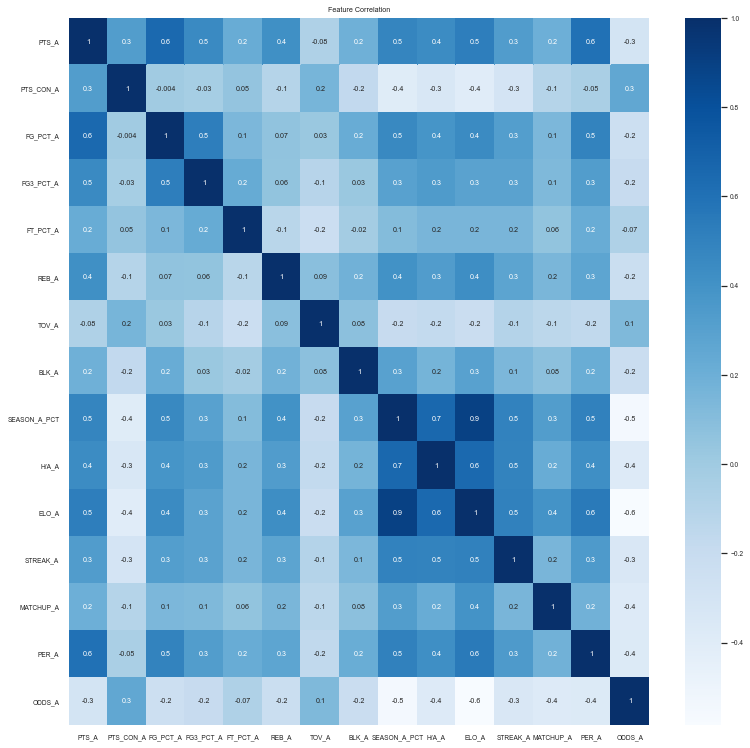

In [69]:
print('\nGetting the feature correlation matrix...')

import seaborn as sns

try:
    dependent_variables = dataset.iloc[:,5:20]
    corrmat = dependent_variables.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(13,13))
    title = 'Feature Correlation'
    plt.title(title)
    #plot heat map
    sns.set(font_scale=0.6)
    g=sns.heatmap(dependent_variables.corr(),annot=True,cmap='Blues', fmt='0.1g')
    plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
    plt.show()
except:
    print('No correlation matrix for the selected model.')

In [70]:
print('\nGetting classification model with the best predictions...')

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_transformed = sc.fit_transform(X)

modelCont = 0
highestAcc = 0
probs = dict()
total_invested = dict()
while True:
    try:
        total_invested[results[modelCont]['model']] = 0
        if results[modelCont]['model'] == 'LSTM':
            features_lstm, labels_lstm, info_lstm = parse_lstm_data(X_lstm, y_lstm)
            pred = results[modelCont]['classifier'].predict(features_lstm)
            results[modelCont]['pred'] = pred
            probs['LSTM'] =  pred
            pred_winner = (results[modelCont]['pred'] > 0.5)
            results[modelCont]['pred_winner'] = pred_winner
            results[modelCont]['acc_test'] = accuracy_score(labels_lstm, results[modelCont]['pred_winner'])
        else:
            results[modelCont]['pred'] = results[modelCont]['classifier'].predict(X_transformed)
            if results[modelCont]['model'] == 'ANN':
                probs['ANN'] =  results[modelCont]['pred']
                results[modelCont]['pred'] = (results[modelCont]['pred'] > 0.5)
            else:
                probs[results[modelCont]['model']] =  results[modelCont]['classifier'].predict_proba(X_transformed)
            results[modelCont]['acc_test'] = accuracy_score(y, results[modelCont]['pred'])
        if results[modelCont]['acc_test'] > highestAcc:
            y_pred = results[modelCont]['pred']
            highestAcc = results[modelCont]['acc_test']
            print('Using predictions from {} model: {}'.format(results[modelCont]['model'], results[modelCont]['acc_test']))
        modelCont += 1
    except IndexError:
        break

results.sort(key=lambda x: x['acc_test'], reverse=True)


Getting classification model with the best predictions...
Using predictions from logistic Regression model: 0.6617262423714037
Using predictions from Naive Bayes model: 0.6625980819529207
Using predictions from Random Forest model: 0.6774193548387096


In [71]:
matchups_baseline = dataset[((dataset['MATCHUP_A'] >= dataset['MATCHUP_B']) & (dataset['WINNER'] == 1)) | 
                   ((dataset['MATCHUP_B'] > dataset['MATCHUP_A']) & (dataset['WINNER'] == 0))]
odds_baseline = dataset[((dataset['ODDS_A'] <= dataset['ODDS_B']) & (dataset['WINNER'] == 1)) | 
                   ((dataset['ODDS_B'] < dataset['ODDS_A']) & (dataset['WINNER'] == 0))]

print('\nResults Classification ({}):'.format(season_test))
results.sort(key=lambda x: x['acc_test'], reverse=True)
[print('{}:\t{:.4f}'.format(x['model'], x['acc_test'])) for x in results]
print('Baseline Last Machups:\t{:.4f}'.format(100*len(matchups_baseline.index)/len(dataset.index)))
print('Baseline Odds:\t{:.4f}'.format(100*len(odds_baseline.index)/len(dataset.index)))


Results Classification (2018-2018):
Random Forest:	0.6774
Naive Bayes:	0.6626
logistic Regression:	0.6617
Kernel SVM:	0.6600
LSTM:	0.6296
ANN:	0.5894
Baseline Last Machups:	57.8901
Baseline Odds:	67.3060


In [72]:
print('\nGetting the probabilities of the best model possible...')

for res in results:
    try:
        y_prob = res['classifier'].predict_proba(X_transformed)
        print('Using the {} model for probability tracking!'.format(res['model']))
        break
    except AttributeError:
        continue


Getting the probabilities of the best model possible...
Using the Random Forest model for probability tracking!


In [73]:
print('\nDisplaying data for the {} model...'.format(results[0]['model']))
cm = confusion_matrix(y.ravel(), y_pred.ravel())
acc_score = accuracy_score(y, y_pred)
print(cm)
print(acc_score)


Displaying data for the Random Forest model...
[[252 219]
 [151 525]]
0.6774193548387096


In [74]:
print("\nGetting data from the regular models for visualization...")
profit = 0
money_by_date = []
bets_tracking_matchups = [0]
bets_tracking_odds = [0]
money_by_team = dict()
bets = []
index_lstm = 0
pred_winner_lstm = [x['pred_winner'] for x in results if x['model'] == 'LSTM'][0]
money_by_date.append([dataset.iloc[0,2], dict(zip([x['model'] for x in results], [0 for x in results])),  dict(zip([x['model'] for x in results], [0 for x in results]))])
for index, game in dataset.iterrows():
    if game['GAME_DATE'] != money_by_date[-1][0]:    
        bets_tracking_matchups.append(bets_tracking_matchups[-1])
        bets_tracking_odds.append(bets_tracking_odds[-1])
        money_by_date.append([game['GAME_DATE'],  dict(zip([x['model'] for x in results], [0 for x in results])), dict(money_by_date[-1][2])])

    game_money = 0
    bet_value = get_bet_value(y_prob[index,0])
    if (y_pred[index] == 1 and (game['ODDS_A'] > min_threshold and game['ODDS_A'] < max_threshold)) or (y_pred[index] == 0 and (game['ODDS_B'] > min_threshold and game['ODDS_B'] < max_threshold)):
        if game['TEAM_A'] not in money_by_team:
            money_by_team[game['TEAM_A']] = 0
        if game['TEAM_B'] not in money_by_team:
            money_by_team[game['TEAM_B']] = 0

        game_money = check_model_performance_on_game(game, y_pred[index], bet_value)
        if game['WINNER'] == y_pred[index] and game['WINNER'] == 1:
            bets.append(['A', game['ODDS_A'], y_prob[index,1], 1])
            money_by_team[game['TEAM_A']] += game_money
        elif game['WINNER'] == y_pred[index] and game['WINNER'] == 0:
            bets.append(['B', game['ODDS_B'], y_prob[index,0], 1])
            money_by_team[game['TEAM_B']] += game_money
        else:
            if y_pred[index] == 1:
                bets.append(['A', game['ODDS_A'], y_prob[index,1], 0])
                money_by_team[game['TEAM_A']] += game_money
            else:
                bets.append(['B', game['ODDS_B'], y_prob[index,0], 0])
                money_by_team[game['TEAM_B']] += game_money

    profit += game_money
    bets_tracking_matchups[-1] += check_game_with_matchups(game, bet_value)
    bets_tracking_odds[-1] += check_game_with_odds(game, bet_value)

    for model in money_by_date[-1][1]:
        if model == 'LSTM':
            if index_lstm < len(info_lstm) and info_lstm[index_lstm][0] == money_by_date[-1][0]:
                bet_value = get_bet_value(probs[model][index_lstm,0])
                prediction = pred_winner_lstm[index_lstm]
                game_money_model = check_model_performance_on_game_lstm(info_lstm[index_lstm], prediction, bet_value)
                index_lstm += 1
            else:
                game_money_model = 0
        else:
            bet_value = get_bet_value(probs[model][index,0])
            prediction = next(x['pred'][index] for x in results if x['model'] == model)
            game_money_model = check_model_performance_on_game(game, prediction, bet_value)
        if game_money_model != 0:
            total_invested[model] += bet_value
        money_by_date[-1][1][model] += game_money_model
        money_by_date[-1][2][model] += game_money_model




Getting data from the regular models for visualization...


In [75]:
print('\nProfit and margin by model...')
for model in money_by_date[-1][1]:
    print('Model: {} \t// Invested: {} \t// Won: {} \t// Margin: {:.2f}%'.format(model, total_invested[model], money_by_date[-1][2][model], 100*money_by_date[-1][2][model]/total_invested[model]))


Profit and margin by model...
Model: Random Forest 	// Invested: 1422.9174010012023 	// Won: -110.00552786087086 	// Margin: -7.73%
Model: Naive Bayes 	// Invested: 1830.3621466332181 	// Won: -186.4979077461088 	// Margin: -10.19%
Model: logistic Regression 	// Invested: 1393.3474357662155 	// Won: -126.42332948724876 	// Margin: -9.07%
Model: Kernel SVM 	// Invested: 1384.7406324008855 	// Won: -149.35166163810993 	// Margin: -10.79%
Model: LSTM 	// Invested: 1061.8288883566856 	// Won: -134.48777230679988 	// Margin: -12.67%
Model: ANN 	// Invested: 1161.0846441984177 	// Won: -95.90742200016979 	// Margin: -8.26%


In [76]:
print('\nPlotting charts...')

models_tracking =  [np.array([x[2][model] for x in money_by_date], dtype=np.float32) for model in money_by_date[-1][1]]

money_by_date = np.array(money_by_date, dtype=str)
correct_bets = list(filter(lambda x: x[3] == 1, bets))
missed_bets = list(filter(lambda x: x[3] == 0, bets))
correct_bets_odds = np.array(list(map(lambda x: x[1], correct_bets)))
missed_bets_odds = np.array(list(map(lambda x: x[1], missed_bets)))
# correct_bets_prob = np.array(list(map(lambda x: x[2], correct_bets)))
# missed_bets_prob = np.array(list(map(lambda x: x[2], missed_bets)))
correct_bets_home = np.array(list(map(lambda x: x[0], correct_bets)))
missed_bets_home = np.array(list(map(lambda x: x[0], missed_bets)))

money_by_team = dict(sorted(money_by_team.items(), key=lambda x: x[1]))
money_by_team_labels = np.array(list(money_by_team.keys()), dtype=str)
money_by_team_values = np.array(list(money_by_team.values()), dtype=np.float32)


Plotting charts...


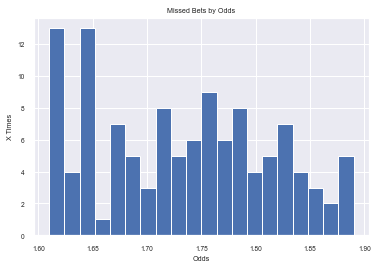

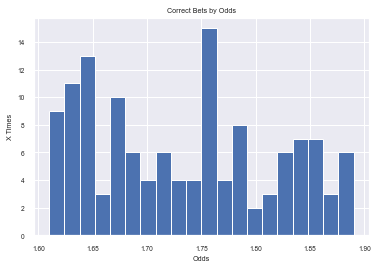

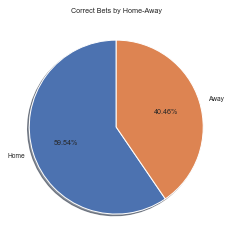

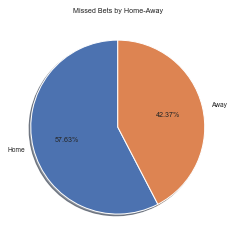

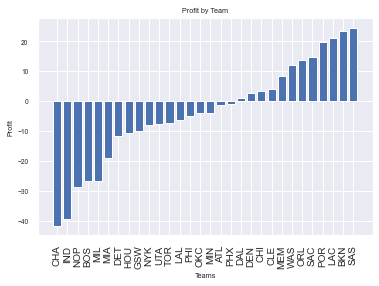

In [77]:
plot_hist('Missed Bets by Odds', 'Odds', 'X Times', missed_bets_odds)

plot_hist('Correct Bets by Odds', 'Odds', 'X Times', correct_bets_odds)

plot_pie_chart('Correct Bets by Home-Away', ['Home', 'Away'], correct_bets_home)

plot_pie_chart('Missed Bets by Home-Away', ['Home', 'Away'], missed_bets_home)

plot_bar('Profit by Team', 'Teams', 'Profit', money_by_team_labels, money_by_team_values)

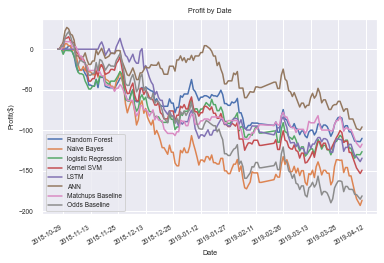

In [78]:
xpoints = money_by_date[:,0].astype(np.datetime64)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
for model in models_tracking:
    plt.plot(xpoints, model)
plt.plot(xpoints, bets_tracking_matchups)
plt.plot(xpoints, bets_tracking_odds)

title = "Profit by Date"
plt.legend([x['model'] for x in results] + ['Matchups Baseline', 'Odds Baseline'], loc='lower left')
plt.ylabel("Profit($)")
plt.xlabel("Date")
plt.title(title)
plt.gcf().autofmt_xdate()
plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
plt.show()